# Exploratory analysis

#Nota: hay una analisis para mostrar la diferencia de consumo (notable) entre ACORN. Quizas puedo predecir POR acorn y asi me evito tener que usarlas y crear dummies and so on

## Import Libraries

In [4]:
import os
import sys
#from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import datetime

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


init_notebook_mode(connected=True)

## Create folder shortcuts

In [6]:
folder = "/Users/mariabelenalberti/Downloads/smart-meters-in-london/"
folder_savepicture = "Users/mariabelenalberti/Downloads/"

## Load datasets

In [7]:
dataset_folder = "daily_dataset/"
df_daily = pd.read_csv(folder+dataset_folder+"block_0.csv")
df_daily.head()

dataset_folder="halfhourly_dataset/"
df_hh = pd.read_csv(folder + dataset_folder + "block_0.csv")
df_hh.head()

dataset_folder="hhblock_dataset/"
df_hhb=pd.read_csv(folder+dataset_folder+"block_0.csv")
df_hhb.head()

df_detailsacorn=pd.read_csv(folder+"/acorn_details.csv",encoding = "ISO-8859-1")
df_detailsacorn.head()

df_bankholidays=pd.read_csv(folder+"/uk_bank_holidays.csv",encoding = "ISO-8859-1")
df_bankholidays.head()

df_weatherdaily=pd.read_csv(folder+"/weather_daily_darksky.csv",encoding = "ISO-8859-1")
df_weatherdaily.head()

df_weatherhourly=pd.read_csv(folder+"/weather_hourly_darksky.csv",encoding = "ISO-8859-1")
df_weatherhourly.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [65]:
dataset_folder="daily_dataset/"

list_dailyselection=[]

for file in tqdm(os.listdir(folder+dataset_folder)):
    if file.endswith(".csv"):
        #print(file)
        df_daily = pd.read_csv(folder+dataset_folder+file)
        #print(df_daily.head())
        df_daily_selection = df_daily[df_daily["energy_count"]==48][["LCLid","day"]].dropna()
        list_dailyselection.append(df_daily_selection)

## Number of meters (choose period for optimum analysis)

In [66]:
df_dailyselection = pd.concat(list_dailyselection,axis=0)
df_dailyselection["day"] = pd.to_datetime(df_dailyselection["day"])
df_dailyselection.head()

,LCLid,day
1,MAC000027,2011-12-08
2,MAC000027,2011-12-09
3,MAC000027,2011-12-10
4,MAC000027,2011-12-11
5,MAC000027,2011-12-12


In [67]:
# Make the count
df_count=df_dailyselection.groupby(["day"]).count()

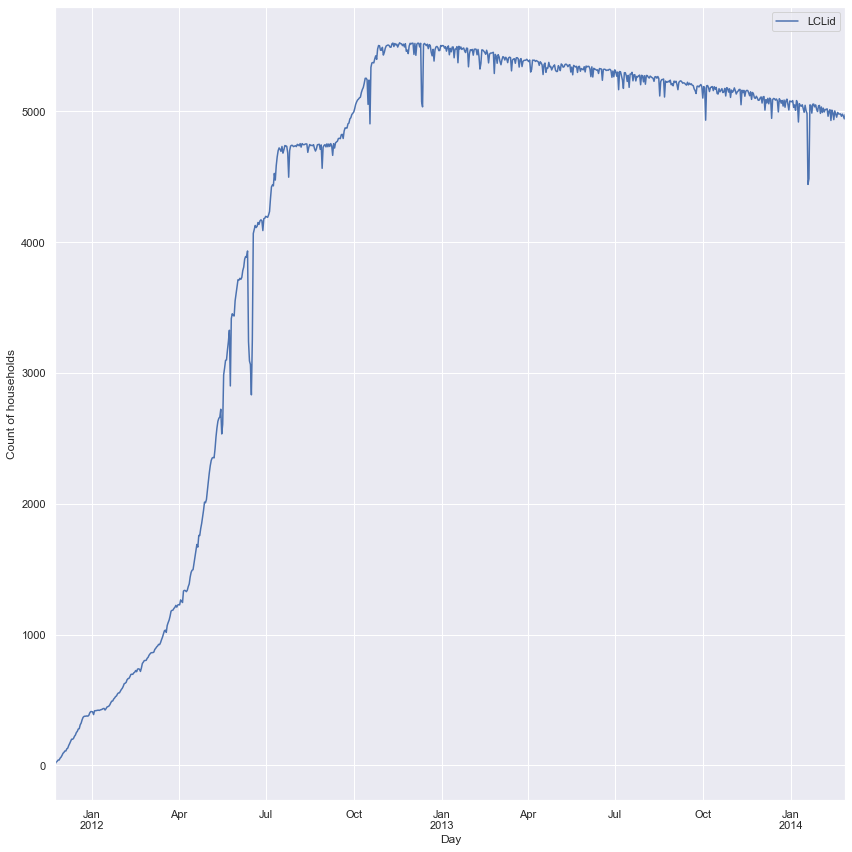

In [70]:
fig,ax=plt.subplots(figsize=(12,12))
df_count.plot(ax=ax)
plt.xlabel("Day")
plt.ylabel("Count of households")
fig.tight_layout()
plt.show()
#ax.figure.savefig(folder_savepicture+"count_householdday.png")

## Choose households

In [71]:
start_date=datetime.datetime(year=2013,month=1,day=1)
end_date=datetime.datetime(year=2014,month=1,day=1)

In [72]:
df_dailyselection_zoom=df_dailyselection[(df_dailyselection["day"]>=start_date) & (df_dailyselection["day"]<end_date)]

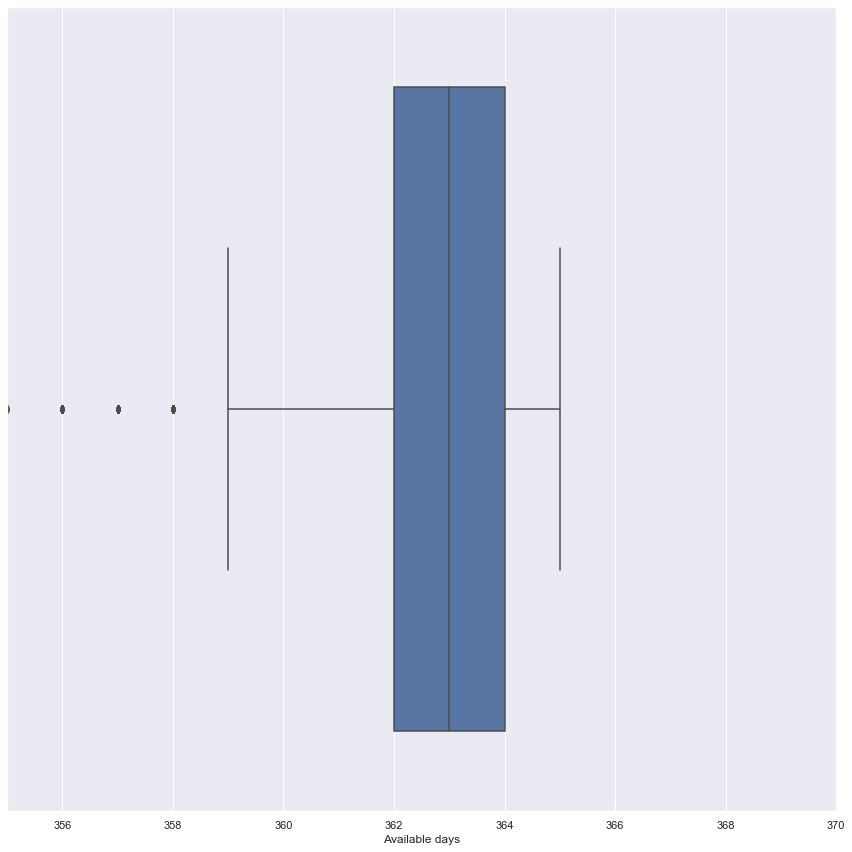

In [73]:
# Represents the number of day avaialble per device in the date range

df_countperid=df_dailyselection_zoom.groupby(["LCLid"]).count()

fig,ax=plt.subplots(figsize=(12,12))
sns.boxplot(df_countperid)
plt.xlim(355,370)
plt.xlabel("Available days")
fig.tight_layout()
plt.show()
#ax.figure.savefig(folder_savepicture+"boxplot_availalbedayhousehold.png")

In [74]:
list_devices=list(df_countperid[df_countperid>365].index)
print("Households for the rest of the study: {} households".format(len(list_devices)))

Households for the rest of the study: 5528 households


In [75]:
# Find the block file with the households
df_householddetails=pd.read_csv(folder+'informations_households.csv')
df_householddetails_selection=df_householddetails[df_householddetails["LCLid"].isin(list_devices)]
df_householddetails_selection.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0
5,MAC003579,Std,ACORN-A,Affluent,block_0


In [76]:
#Lost of households during the selection
print("LOST of households:",len(df_householddetails)-len(df_householddetails_selection),"households")

LOST of households: 38 households


## Consumption analysis

In [77]:
# Get the general heatmap
dataset_folder="hhblock_dataset/"
pbar = tqdm(total=len(df_householddetails_selection))

list_heatmap=[]
for block in df_householddetails_selection["file"].unique():
    file="{}.csv".format(block)
    df_hhblock=pd.read_csv(folder+dataset_folder+file).dropna()
    df_hhblock["day"]=pd.to_datetime(df_hhblock["day"])
    df_hhblock=df_hhblock[(df_hhblock["day"]>=start_date) & (df_hhblock["day"]<end_date)]
    for household in df_householddetails_selection[df_householddetails_selection["file"]==block]["LCLid"].unique():
        df_hhblock_household=df_hhblock[df_hhblock["LCLid"]==household].drop(["LCLid"],axis=1)
        df_hhblock_household["day"]=df_hhblock_household.apply(lambda row:row["day"].strftime("%Y-%m-%d"),axis=1)
        if len(df_hhblock_household)>=357:
            list_heatmap.append(df_hhblock_household)
        pbar.update(1)
pbar.close()

In [78]:
df_generalheatmap=pd.concat(list_heatmap,axis=0).groupby(["day"]).mean()

In [79]:
stdate=datetime.datetime.now().replace(hour=0,minute=0)
df_generalheatmap.columns=["{}-{}".format((stdate+datetime.timedelta(minutes=i*30)).strftime("%H:%M"),(stdate+datetime.timedelta(minutes=(i+1)*30)).strftime("%H:%M")) for i in range(48)]

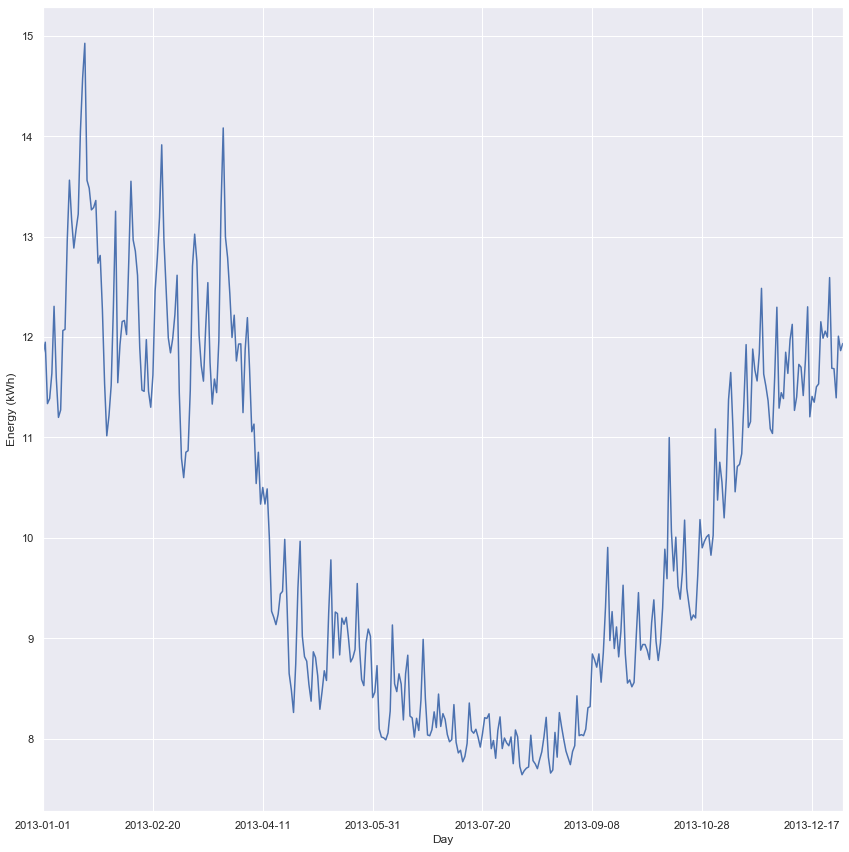

In [82]:
fig,ax=plt.subplots(figsize=(12,12))
#plot_heatmap(fig, ax,df_generalheatmap,"")
df_generalheatmap.sum(axis=1).plot(ax=ax,kind="line",use_index=True)
plt.xlabel("Day")
plt.ylabel("Energy (kWh)")
fig.tight_layout()
plt.show()
#ax.figure.savefig(folder_savepicture+"timeseries_sumall.png")



In [83]:
df_weatherdaily["time"]=pd.to_datetime(df_weatherdaily["time"])
df_weatherdaily=df_weatherdaily.sort_values(["time"])
df_weatherdaily["day"]=df_weatherdaily.apply(lambda row:row["time"].strftime("%Y-%m-%d"),axis=1)
df_weatherdaily["temperatureMean"]=df_weatherdaily.apply(lambda row:(row["temperatureMax"]+row["temperatureMin"])/2,axis=1)
df_weatherdaily=df_weatherdaily.drop_duplicates(["day"])
df_weatherdaily=df_weatherdaily.set_index(("day"))
df_weatherdaily.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,temperatureMean
day,,,,,,,,,,,,,,,,,,,,,
2011-11-01,15.57,2011-11-01 15:00:00,208,partly-cloudy-day,10.13,2011-11-01 22:00:00,0.36,2.45,1009.46,2011-11-01 22:00:00,...,2011-11-01 06:54:29,2011-11-01 15:00:00,2011-11-01 10:00:00,Partly cloudy until evening.,2011-11-02 03:00:00,9.01,2011-11-01 15:00:00,2011-11-02 03:00:00,0.21,12.625
2011-11-02,15.19,2011-11-02 23:00:00,134,partly-cloudy-night,10.23,2011-11-02 03:00:00,0.39,4.39,1004.79,2011-11-02 03:00:00,...,2011-11-02 06:56:16,2011-11-02 13:00:00,2011-11-02 09:00:00,Partly cloudy throughout the day.,2011-11-02 19:00:00,7.33,2011-11-02 23:00:00,2011-11-02 19:00:00,0.24,12.035
2011-11-03,17.41,2011-11-03 14:00:00,154,partly-cloudy-day,13.39,2011-11-03 21:00:00,0.52,3.99,993.40,2011-11-03 21:00:00,...,2011-11-03 06:58:03,2011-11-03 14:00:00,2011-11-03 10:00:00,Partly cloudy throughout the day.,2011-11-04 07:00:00,12.79,2011-11-03 14:00:00,2011-11-04 07:00:00,0.27,15.100
2011-11-04,15.54,2011-11-04 11:00:00,179,fog,12.03,2011-11-04 23:00:00,0.50,2.62,995.54,2011-11-04 23:00:00,...,2011-11-04 06:59:49,2011-11-04 11:00:00,2011-11-04 10:00:00,Foggy overnight.,2011-11-05 02:00:00,11.53,2011-11-04 11:00:00,2011-11-05 02:00:00,0.31,13.535
2011-11-05,13.94,2011-11-05 15:00:00,346,fog,10.96,2011-11-05 02:00:00,0.65,2.70,1007.39,2011-11-05 02:00:00,...,2011-11-05 07:01:36,2011-11-05 15:00:00,2011-11-05 10:00:00,Foggy in the morning.,2011-11-06 05:00:00,10.17,2011-11-05 15:00:00,2011-11-06 06:00:00,0.34,12.055


In [84]:
df_glob=pd.concat([df_generalheatmap.sum(axis=1),df_weatherdaily["temperatureMean"]],axis=1).dropna()
df_glob.columns=["total_consumption","average_outdoortemperature"]
df_glob.head()

/Users/mariabelenalberti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,total_consumption,average_outdoortemperature
2013-01-01,11.832464,5.400
2013-01-02,11.947462,7.065
2013-01-03,11.335781,10.530
2013-01-04,11.386660,9.480
2013-01-05,11.637469,9.250


# ARIMA Model

In [9]:
# dataset con half hourly df_hh 
folder = "/Users/mariabelenalberti/Downloads/smart-meters-in-london/"
dataset_folder="daily_dataset.csv/"
daily_complete_dataset = pd.read_csv(folder + dataset_folder + "daily_dataset.csv")

In [11]:
daily_complete_dataset.head()
len(daily_complete_dataset)

3510433

In [ ]:
#Data set daily

In [23]:
folder = "/Users/mariabelenalberti/Downloads/smart-meters-in-london/"
dataset_folder="daily_dataset/"

import glob
import pandas as pd


path = "/Users/mariabelenalberti/Downloads/smart-meters-in-london/daily_dataset"
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
daily_complete = pd.concat(dfs, ignore_index=True)

In [24]:
big_frame.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000027,2011-12-07,0.1470,0.159880,0.408,25,0.062123,3.997,0.103
1,MAC000027,2011-12-08,0.1705,0.193479,0.459,48,0.077042,9.287,0.105
2,MAC000027,2011-12-09,0.1440,0.156771,0.365,48,0.051995,7.525,0.101
3,MAC000027,2011-12-10,0.2415,0.264250,0.814,48,0.135007,12.684,0.101
4,MAC000027,2011-12-11,0.2785,0.288438,0.540,48,0.112697,13.845,0.126


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
rolling_mean = df.rolling(window = 30).mean()
rolling_std = df.rolling(window = 30).std()plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()